<a href="https://colab.research.google.com/github/Rispectech/Unet/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import os
import glob
import shutil
import random
import pandas as pd
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
# os.chdir("/content/drive/MyDrive/unet")
# if os.path.isdir('/content/drive/MyDrive/unet/train') is False:
#     os.makedirs('/content/drive/MyDrive/unet/train/images')
#     os.makedirs('/content/drive/MyDrive/unet/test/images')
#     os.makedirs('/content/drive/MyDrive/unet/valid/images')
#     os.makedirs('/content/drive/MyDrive/unet/train/mask')
#     os.makedirs('/content/drive/MyDrive/unet/test/mask')
#     os.makedirs('/content/drive/MyDrive/unet/valid/mask')
#     for i in random.sample(glob.glob('/content/drive/MyDrive/unet/images/**'), 400):
#         print(i)
#         shutil.move(i, '/content/drive/MyDrive/unet/train/images')   
#     for i in random.sample(glob.glob('/content/drive/MyDrive/unet/images/**'), 50):
#         shutil.move(i, '/content/drive/MyDrive/unet/test/images')
#     for i in random.sample(glob.glob('/content/drive/MyDrive/unet/images/**'), 50):
#         shutil.move(i, '/content/drive/MyDrive/unet/valid/images')
#     for i in random.sample(glob.glob('/content/drive/MyDrive/unet/masks/**'), 400):
#         shutil.move(i, '/content/drive/MyDrive/unet/train/mask')  
#     for i in random.sample(glob.glob('/content/drive/MyDrive/unet/masks/**'), 50):
#         shutil.move(i, '/content/drive/MyDrive/unet/test/mask')
#     for i in random.sample(glob.glob('/content/drive/MyDrive/unet/masks/**'), 50):
#         shutil.move(i, '/content/drive/MyDrive/unetvalid/mask')


In [132]:
train_path = "/content/drive/MyDrive/Unet/train"
test_path = "/content/drive/MyDrive/Unet/test"
valid_path = "/content/drive/MyDrive/Unet/valid"

In [133]:
image_path = "/content/drive/MyDrive/Unet_data/images/"
mask_path = "/content/drive/MyDrive/Unet_data/masks/"

# image_path = "/content/drive/MyDrive/UNET/images/"
# mask_path = "/content/drive/MyDrive/UNET/masks/"


In [134]:
IMG_height = 128
IMG_width = 128
IMG_channel = 1 
# IMG_height = 512
# IMG_width = 512
# IMG_channel = 1 

In [135]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)
# image_generator = train_datagen.flow_from_directory(
#         image_path,
#         batch_size=32,
#         class_mode='binary')
# mask_generator = test_datagen.flow_from_directory(
#         mask_path,
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')
# print(image_generator)

In [136]:
image_ids = next(os.walk(image_path))[2] # list of names all images in the given path
print("No. of images = ", len(image_ids))
print(image_ids)

No. of images =  500
['1.png', '0.png', '102.png', '10.png', '100.png', '101.png', '121.png', '119.png', '106.png', '120.png', '103.png', '105.png', '117.png', '118.png', '115.png', '11.png', '113.png', '104.png', '110.png', '107.png', '109.png', '114.png', '108.png', '112.png', '12.png', '111.png', '116.png', '126.png', '13.png', '124.png', '128.png', '134.png', '135.png', '130.png', '129.png', '133.png', '132.png', '122.png', '123.png', '127.png', '125.png', '131.png', '150.png', '136.png', '15.png', '145.png', '140.png', '14.png', '146.png', '139.png', '144.png', '137.png', '142.png', '149.png', '143.png', '147.png', '138.png', '141.png', '148.png', '152.png', '158.png', '156.png', '16.png', '157.png', '165.png', '161.png', '159.png', '160.png', '153.png', '164.png', '155.png', '163.png', '162.png', '151.png', '154.png', '170.png', '18.png', '171.png', '169.png', '166.png', '178.png', '175.png', '167.png', '181.png', '179.png', '182.png', '174.png', '176.png', '17.png', '177.png', '

In [137]:
X = np.zeros((len(image_ids), IMG_height, IMG_width, 1), dtype=np.float32)
y = np.zeros((len(image_ids), IMG_height, IMG_width, 1), dtype=np.float32)
len(X)

500

In [138]:
import tqdm
from tqdm import tqdm_notebook, tnrange

In [153]:
for n,i in tqdm_notebook(enumerate(image_ids), total=len(image_ids)):
    # Load images
      img = load_img(image_path +str(i), color_mode="grayscale")
      x_img = img_to_array(img)
      x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
      # Load masks
      mask_i = str(i).split(".")[0] + "_mask.png"
      mask = img_to_array(load_img(mask_path + mask_i, color_mode="grayscale"))
      mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
      # Save images
      X[n] = x_img/255.0
      y[n] = mask/255.0
      # X[n] = x_img
      # y[n] = mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/500 [00:00<?, ?it/s]

In [140]:
# print(X)
# print(y)


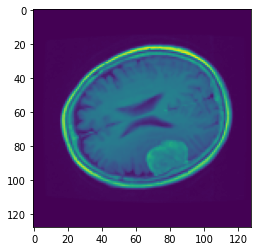

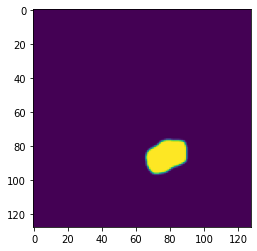

In [154]:
image_x = random.randint(0,len(X))
plt.imshow(np.squeeze(X[image_x]))
plt.show()
plt.imshow(np.squeeze(y[image_x]))
plt.show()

In [155]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [156]:
# model

input = Input((IMG_height,IMG_width,IMG_channel))

# Contracting path

c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding = "same")(input)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding = "same")(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)


c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 128, 128, 16  160         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_63 (Dropout)           (None, 128, 128, 16  0           ['conv2d_133[0][0]']             
                                )                                                           

In [157]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
15/15 [==============================] - 5s 199ms/step - loss: 0.4061 - accuracy: 0.8706 - val_loss: 0.2054 - val_accuracy: 0.9751
Epoch 2/10
15/15 [==============================] - 2s 162ms/step - loss: 0.0989 - accuracy: 0.9744 - val_loss: 0.0809 - val_accuracy: 0.9751
Epoch 3/10
15/15 [==============================] - 2s 161ms/step - loss: 0.0712 - accuracy: 0.9744 - val_loss: 0.0860 - val_accuracy: 0.9751
Epoch 4/10
15/15 [==============================] - 2s 161ms/step - loss: 0.0628 - accuracy: 0.9744 - val_loss: 0.0598 - val_accuracy: 0.9751
Epoch 5/10
15/15 [==============================] - 2s 162ms/step - loss: 0.0527 - accuracy: 0.9744 - val_loss: 0.0555 - val_accuracy: 0.9751
Epoch 6/10
15/15 [==============================] - 2s 162ms/step - loss: 0.0462 - accuracy: 0.9744 - val_loss: 0.0714 - val_accuracy: 0.9751
Epoch 7/10
15/15 [==============================] - 2s 162ms/step - loss: 0.0430 - accuracy: 0.9744 - val_loss: 0.0546 - val_accuracy: 0.9751
Epoch 

In [145]:
print(results)

In [158]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 0s 43ms/step


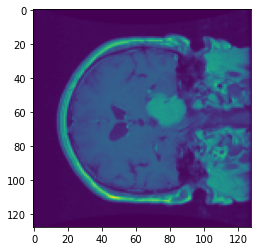

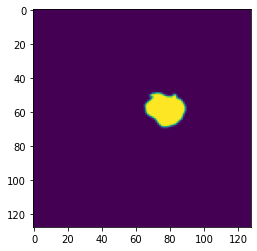

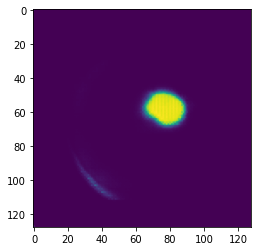

In [159]:
ix = random.randint(0, len(preds_train))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train[ix]))
plt.show()

In [160]:
preds_train[ix]

array([[[4.06732894e-02],
        [3.48145928e-04],
        [1.00682781e-03],
        ...,
        [2.97298953e-07],
        [2.17946377e-04],
        [1.43993192e-03]],

       [[1.09416278e-05],
        [2.27957548e-06],
        [2.16799842e-10],
        ...,
        [1.87549282e-12],
        [6.37122688e-10],
        [7.63723563e-07]],

       [[7.80441696e-05],
        [1.36694378e-09],
        [2.89018592e-12],
        ...,
        [1.30466251e-17],
        [6.86851661e-12],
        [1.55904402e-07]],

       ...,

       [[3.76340904e-04],
        [8.47833164e-08],
        [4.81304163e-11],
        ...,
        [5.64618187e-12],
        [8.29575797e-10],
        [3.39545613e-06]],

       [[3.25187598e-03],
        [1.31840661e-05],
        [5.77516310e-08],
        ...,
        [3.05520098e-09],
        [7.46921245e-08],
        [4.60369556e-05]],

       [[4.97120097e-02],
        [3.19476170e-03],
        [7.03601327e-05],
        ...,
        [1.57032957e-06],
        [1.0801